In [1]:
import matplotlib.pyplot as plt

# utility functions (common functions)
def plot_total_reward(reward_history):
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.plot(range(len(reward_history)), reward_history)
    plt.show()

In [2]:
import numpy as np
import gymnasium as gym
from dezero import Model
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L

In [5]:
class Policy(Model):
    def __init__(self, action_size):
        super().__init__()
        self.l1 = L.Linear(128)
        self.l2 = L.Linear(action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.softmax(self.l2(x))
        return x

class Agent:
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0002
        self.action_size = 2

        self.memory = []
        self.pi = Policy(self.action_size)
        self.optimizer = optimizers.Adam(self.lr)
        self.optimizer.setup(self.pi)

    def get_action(self, state):
        state = state[np.newaxis, :]
        probs = self.pi(state)
        probs = probs[0]
        action = np.random.choice(len(probs), p=probs.data)
        return action, probs[action]
    
    def add(self, reward, prob):
        data = (reward, prob)
        self.memory.append(data)

    def update(self):
        self.pi.cleargrads()

        G, loss = 0, 0
        for reward, prob in reversed(self.memory):
            G = reward + self.gamma * G

        for reward, prob in self.memory:
            loss += -F.log(prob) * G

        loss.backward()
        self.optimizer.update()
        self.memory = []


In [6]:
episodes = 3000
env = gym.make('CartPole-v1', render_mode='rgb_array')
agent = Agent()
reward_history = []

for episode in range(episodes):
    state = env.reset()[0]
    done = False
    total_reward = 0

    while not done:
        action, prob = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated | truncated

        agent.add(reward, prob)
        state = next_state
        total_reward += reward
    
    agent.update()
    reward_history.append(total_reward)

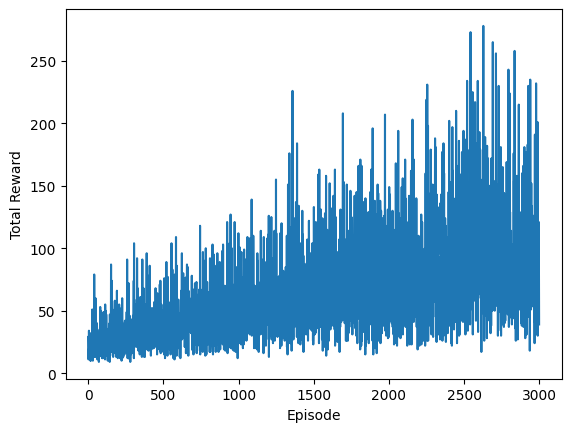

In [7]:
plot_total_reward(reward_history)